In [8]:
import numpy as np
import bubble as bubl

import pickle
import lmfit

%matplotlib notebook
from matplotlib import pyplot as plt

In [2]:
# Load video settings

time_switch = 10.0 # s

neighbourhood = 100 # frames about switch taken into account

# Variables given by lab-book
microscope_scale = 0.5e-3 # in meters
viscosity = 1.832e-5
density = 871.0
d = 6e-3 # +/- 0.05 mm
g = 9.807 # in meters per seocond squared
e = 1.6e-19 # in Coulomb
stokes_correction = .874 # [Millikans Paper]
mean_free_path = 68e-9 # for air at 25C, [Jennings, S (1988). "The mean free path in air". Journal of Aerosol Science. 19 (2): 159.]

In [61]:
# Load video list
max_th, c_x, c_y, l_x, l_y, duration, voltage = np.loadtxt("./labels-sess-2.csv", skiprows=1, usecols=(1,2,3,4,5,6,7), dtype=float, unpack=True)

In [62]:
videos = np.loadtxt("./labels-sess-2.csv", skiprows=1, usecols=[0], dtype=str)
# DEBUG
# videos = [videos[0]]

In [63]:
# Fill these with traces, times and velocities
# filtered correctly
traces = []
times = []
vels = []
voltages = []

In [64]:
for idx, video in enumerate(videos):
    print("Processing video: " + video)
    print(max_th[idx], duration[idx])
    tr = bubl.Tracker()
    # set params for bubble detection
    tr.params.minArea = 1
    tr.params.maxThreshold = 255 * max_th[idx]
    
    # track bubbles
    tr.load_video(video)
    tr.track()
    
    # gather traces and times
    tr_traces = [b.trajectory for b in tr.bubbles]
    tr_times  = [np.array(range(b.first_seen, b.last_seen+1)) * duration[idx] / (len(tr.frames)-1) for b in tr.bubbles]
    
    # delete tracker
    del tr
    
    print("Found: ", len(tr_traces))
    
    f_traces = []
    f_times = []
    
    # filter traces
    for i, trace in enumerate(tr_traces):
        # Find index at time_switch
        idx_switch = None
        for j in range(1, len(tr_times[i])):
            if tr_times[i][j-1] < time_switch and tr_times[i][j] >= time_switch:
                idx_switch = j
                break
        if idx_switch is None:
                continue
        # Grab slice of 100 frame neighbourhood
        tr = trace[idx_switch - neighbourhood:idx_switch + neighbourhood + 1]
        ti = tr_times[i][idx_switch - neighbourhood:idx_switch + neighbourhood + 1]
        if len(tr) == neighbourhood * 2 + 1:
            f_traces.append(tr)
            f_times.append(ti)
    
    # Rotate points and convert to meters
    theta = np.arctan((l_x[idx]-c_x[idx])/(l_y[idx]-c_y[idx]))
    rotation = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    # Rotate each point and scale to correct units
    origin = np.array([c_x[idx], c_y[idx]])
    for i, trace in enumerate(f_traces):
        f_traces[i] = np.matmul(rotation, (trace-origin).transpose()).transpose()
        f_traces[i] = f_traces[i] * microscope_scale / (l_y[idx]-c_y[idx])
        
    # Obtain approximate instantaneous velocities
    f_vels = []
    for j, trace in enumerate(f_traces):
        f_vels.append(np.array([(trace[i] - trace[i-1]) / (f_times[j][i] - f_times[j][i-1]) for i in range(1, len(trace))]))
        f_traces[j] = trace[:-1]
        f_times[j] = f_times[j][:-1]

    # print data aquired
    print("Filtered: ", len(f_traces))
    traces.extend(f_traces)
    times.extend(f_times)
    vels.extend(f_vels)
    voltages.extend([voltage[idx] for _ in f_traces])

Processing video: ./videos/vid-10.mp4
0.66 24.0
Found:  57
Filtered:  23
Processing video: ./videos/vid-8.mp4
0.65 24.0
Found:  76
Filtered:  43
Processing video: ./videos/vid-11.mp4
0.6 25.0
Found:  97
Filtered:  56
Processing video: ./videos/vid-13.mp4
0.55 24.0
Found:  97
Filtered:  44
Processing video: ./videos/vid-6.mp4
0.55 27.0
Found:  78
Filtered:  37
Processing video: ./videos/vid-9.mp4
0.7 26.0
Found:  25
Filtered:  14
Processing video: ./videos/vid-12.mp4
0.55 28.0
Found:  99
Filtered:  45


# Data Storage (Above is slow...)

In [66]:
# Store the three lists with pickle (optional)
with open("results.p", "wb") as f:
    pickle.dump((traces, times, vels, voltages), f)

In [3]:
# Load pickled data (optional)
with open("results.p", "rb") as f:
    traces, times, vels, voltages = pickle.load(f)

In [4]:
len(traces)

262

# Data Analysis

<IPython.core.display.Javascript object>


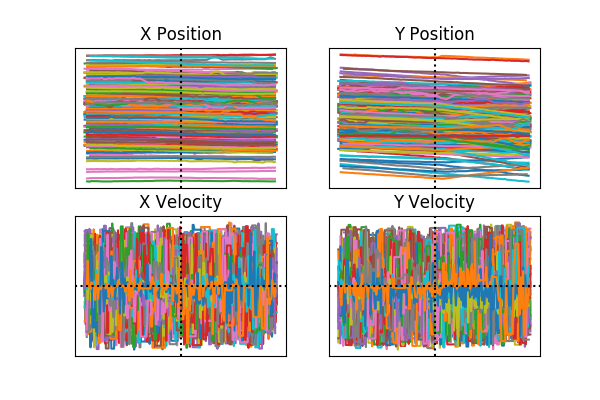

In [9]:
# Plot the obtained data
index = None

_, ax = plt.subplots(2, 2, figsize=(6, 4))

# Position
for i, trace in enumerate(traces):
    if i == index or index == None:
        ax[0][0].plot(times[i], [p[0] for p in trace])
for i, trace in enumerate(traces):
    if i == index or index == None:
        ax[0][1].plot(times[i], [p[1] for p in trace])
# Velocity
for i, vel in enumerate(vels):
    if i == index or index == None:
        ax[1][0].plot(times[i], [v[0] for v in vel])
for i, vel in enumerate(vels):
    if i == index or index == None:
        ax[1][1].plot(times[i], [v[1] for v in vel])
    
for i, _ax in enumerate(ax[0]):
    _ax.set_title("X Position" if i == 0 else "Y Position")
    _ax.axvline(time_switch, color="black", linestyle="dotted")
    _ax.set_xticks([])
    _ax.set_yticks([])
for i, _ax in enumerate(ax[1]):
    _ax.set_title("X Velocity" if i == 0 else "Y Velocity")
    _ax.axvline(time_switch, color="black", linestyle="dotted")
    _ax.axhline(0, color="black", linestyle="dotted")
    _ax.set_xticks([])
    _ax.set_yticks([])

plt.show()

In [15]:
# Analysis functions from lab-book
def q_obs(v_g, v_e, voltage):
    a = 6 * np.pi * np.sqrt(9/2)
    b = viscosity**(3/2) / np.sqrt(density * g)
    c = np.sqrt(abs(v_g)) * (v_e - v_g) / voltage * d
    return a * b * c

def radius(v_g):
    return np.sqrt(abs(9/2 * viscosity / density / g * (-v_g)))

def q(q_obs, alpha=0):
    # Note: alpha = b * l / a in lab-book terms
    return (1/(1+alpha))**(3/2) * q_obs

def q_corrected(v_g, v_e, voltage):
    #return q_obs(v_g, v_e, voltage)
    return q(q_obs(v_g, v_e, voltage), stokes_correction * mean_free_path / radius(v_g))

<IPython.core.display.Javascript object>


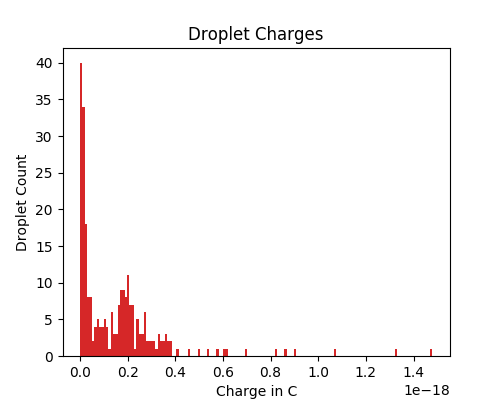

In [16]:
# Determine q_obs for all data items

q_list = []
radius_list = []
for i, vel in enumerate(vels):
    q_list.append(q_corrected(
        np.mean(vel[:neighbourhood], axis=0)[1],
        np.mean(vel[neighbourhood:], axis=0)[1],
        voltages[i]
    ))
    radius_list.append(radius(vel[:neighbourhood]))
q_list = abs(np.array(q_list))

# Plot the results
_, ax = plt.subplots(figsize=(5,4))
ax.hist(q_list, bins=150, color="tab:red")
ax.set_title("Droplet Charges")
ax.set_ylabel("Droplet Count")
ax.set_xlabel("Charge in C")
plt.show()
plt.savefig("./plot_charge_hist.pdf", type="pdf")

In [114]:
centers_by_eye = [1.9, 3.6/2, 5.3/3, 6.5/4, 9.5/6, 11.4/7, 13.1/8]
print(centers_by_eye)
print(np.mean(centers_by_eye))

[1.9, 1.8, 1.7666666666666666, 1.625, 1.5833333333333333, 1.6285714285714286, 1.6375]
1.7058673469387755


In [17]:
n_charged = 0
for q in charges:
    if q > 1.5948e-19 * 0.9:
        n_charged += 1

print(n_charged, len(charges), n_charged / len(charges) * 100)

109 262 41.603053435114504


# Determine the fundamental charge

To determine the fundamental charge, we will fit the supposed identity function
$$
q^{\prime}(q) = \text{round}(q \div e) \times e
$$
where $e$ is the fundamental charge unit t.b.d.

<IPython.core.display.Javascript object>


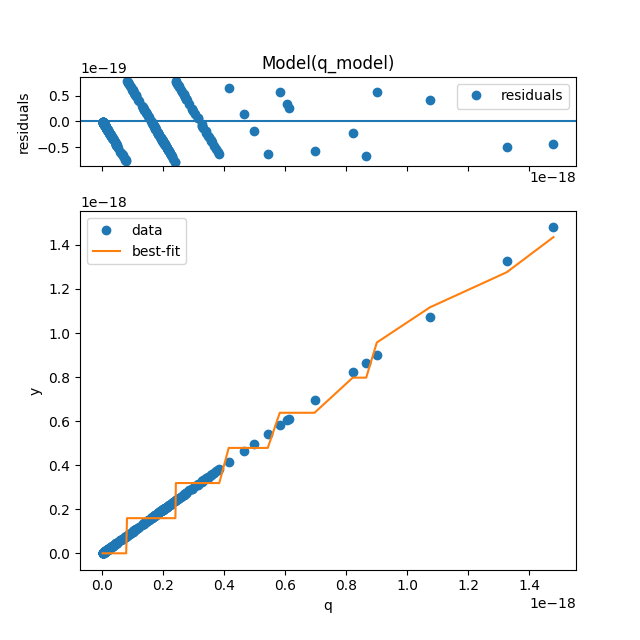

[[Model]]
    Model(q_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 262
    # variables        = 1
    chi-square         = 3.7822e-37
    reduced chi-square = 1.4491e-39
    Akaike info crit   = -23429.6235
    Bayesian info crit = -23426.0551
[[Variables]]
    e:  1.5949e-19 +/- 1.5251e-21 (0.96%) (init = 1.6e-19)



In [18]:
charges = sorted(q_list)

def q_model(q, e):
    return np.round(q/e) * e

model = lmfit.Model(q_model)
params = model.make_params()

params.add("e", value=1.6e-19)
res = model.fit(charges, params, q=charges)

res.plot()
plt.show()
print(res.fit_report())

In [110]:
1.5948e-19

1.5948e-19

<IPython.core.display.Javascript object>


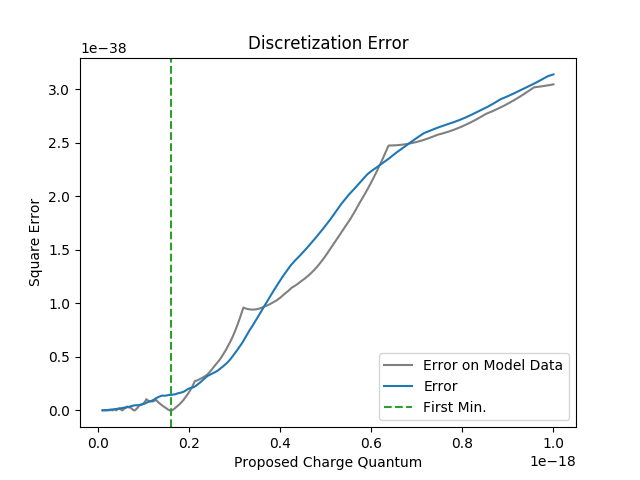

In [19]:
# Interesting test

def square_err(q, f):
    return np.mean((q-f(q))**2)

e_range = np.linspace(1e-20, 1e-18, 1000)
sim_charges = [q_model(q, 1.5948e-19) + 0*np.random.normal(scale=0.4e-19) for q in charges]

_, ax = plt.subplots()
#ax.set_ylim((1.3e-39, 1.7e-39))
#ax.set_xlim((1.3e-19, 1.8e-19))
ax.plot(e_range, [square_err(sim_charges, lambda q: q_model(q, e)) for e in e_range], label="Error on Model Data", color="grey")

ax.plot(e_range, [square_err(charges, lambda q: q_model(q, e)) for e in e_range], label="Error", color="tab:blue")

ax.axvline(x=1.5948e-19, color="tab:green", linestyle="dashed", label="First Min.")
#ax.axvline(x=1.6622e-19, color="tab:red", linestyle="dashed", label="Stationary Point")

ax.set_title("Discretization Error")
ax.set_ylabel("Square Error")
ax.set_xlabel("Proposed Charge Quantum")

ax.legend()

plt.show()
plt.savefig("./plot_charge_fit.pdf", type="pdf")

In [128]:
2 / np.mean(voltages) * 100

0.3929214157168567